In [1]:
import pandas as pd
import tensorflow as tf
import albumentations as A

In [2]:
tf.__version__

'2.4.0'

In [3]:
# create data set
path2data = "/home/Data/"

In [4]:
meanR,meanG,meanB = 0.54568475 ,0.42776844 ,0.3761094
stdR,stdG,stdB = 0.21924357, 0.18996198, 0.17315607
 
def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Resize(224, 224),
        A.Cutout(num_holes=4, max_h_size=4, max_w_size=4, fill_value=0, always_apply=False, p=0.5),
        A.Normalize(mean=(meanR,meanG,meanB), std=(stdR,stdG,stdB)),
    ])

def get_val_transforms():
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(meanR,meanG,meanB), std=(stdR,stdG,stdB)),
    ])

In [5]:
# class Net(tf.keras.Model):
#     def __init__(self, params):
#         super(Net, self).__init__()
    
#     def call(self, x):
#         return x

In [6]:
# def __init__(self, params):
#     super(Net, self).__init__()
    
#     C_in,H_in,W_in=params["input_shape"] 
#     self.dropout_rate=params["drop_rate"] 
#     self.num_fc1 = params["num_fc1"]
    
#     from keras_mixnets import MixNetSmall  # Medium and Large can also be used

#     mixnet = MixNetSmall((224, 224, 3), include_top=False)
    
#     mobilenet_v2.classifier[1] = nn.Linear(in_features, self.num_fc1)
    
#     self.backbone = nn.Sequential(
#                     mobilenet_v2,
#                     nn.BatchNorm1d(num_features=self.num_fc1),
#                     nn.ReLU()
#     )
    
#     self.gender_head = nn.Sequential(
#                             nn.Dropout(p=self.dropout_rate),
#                             nn.Linear(self.num_fc1, 1),
#                             nn.Sigmoid()
#     )
    
#     self.age_head = nn.Sequential(
#                     nn.Linear(self.num_fc1, 1)
#     )

In [7]:
from tensorflow.keras.layers import Input

In [9]:
base_model = tf.keras.applications.EfficientNetB1(
    include_top=True, weights='imagenet',
)

32153600/32148312 [==============================] - 3s 0us/step


In [10]:
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 240, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 240, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 241, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [11]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [12]:
import pandas as pd
import os

In [13]:
train_df = pd.read_csv(os.path.join(path2data, 'all/training.csv'))
val_df = pd.read_csv(os.path.join(path2data, 'all/val.csv'))
test_df = pd.read_csv(os.path.join(path2data, 'all/testing.csv'))

In [14]:
train_df.drop("Unnamed: 0", axis = 1, inplace=True)

In [15]:
train_df.head(1)

,file_name,age,gender
0,/home/Data/AFAD_Dataset/interim/315914-3.jpg,29,1


In [16]:
val_df.drop("Unnamed: 0", axis = 1, inplace=True)
test_df.drop("Unnamed: 0", axis = 1, inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff7123c82b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff7123c8970>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff71243af10>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff7123d4070>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff7123d43d0>],
 'means': []}

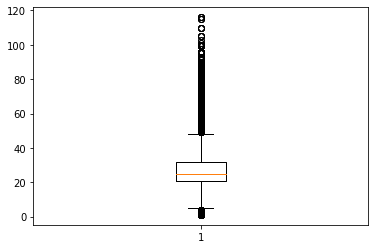

In [23]:
import matplotlib.pyplot as plt

plt.boxplot(train_df['age'].values)

In [24]:
train_df = train_df[train_df['age'] <= 100]
val_df = val_df[val_df['age'] <= 100]
test_df = test_df[test_df['age'] <= 100]

In [35]:
columns = ['age', 'gender']

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="./",
    x_col= "file_name",
    y_col= columns,
    batch_size = 64,
    seed=42, 
    shuffle=True,
    class_mode = "raw",
    target_size = (240, 240)
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory="./",
    x_col= "file_name",
    y_col= columns,
    batch_size = 256,
    seed=42, 
    shuffle=True,
    class_mode = "raw",
    target_size = (240, 240)
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="./",
    x_col= "file_name",
    y_col= columns,
    batch_size = 256,
    seed=42, 
    shuffle=False,
    class_mode = "raw",
    target_size = (240, 240)
)

Found 181412 validated image filenames.
Found 10000 validated image filenames.
Found 10000 validated image filenames.


In [31]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.5)
])

In [37]:
images, labels = next(iter(train_generator))

In [38]:
images.shape

(64, 240, 240, 3)

In [39]:
labels.shape

(64, 2)

In [40]:
print(labels[0])

[31  1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


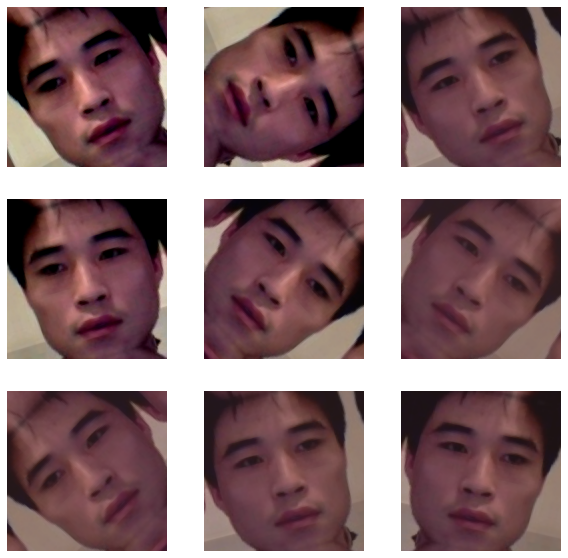

In [41]:
import numpy as np
import matplotlib.pyplot as plt

for image, label in zip(images, labels):
    plt.figure(figsize=(10, 10))
    first_image = image
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")
    break

In [42]:
feature_batch = base_model(images)

In [43]:
print(feature_batch.shape)

(64, 1000)


In [44]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

ValueError: Input 0 of layer global_average_pooling2d is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (64, 1000)

In [26]:
age_layer = tf.keras.layers.Dense(1)
prediction_batch = age_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [27]:
gender_layer = tf.keras.layers.Dense(1)

In [28]:
test_model = tf.keras.applications.MobileNetV3Small(input_shape = (224, 224, 3), include_top=True, weights='imagenet')
test_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [29]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  243


In [30]:
base_model.trainable = False

In [47]:
def create_model():
    # Create the base model from the pre-trained model MobileNet V3 small
    base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights='imagenet', input_shape=(240, 240, 3))
    base_model.trainable = False
    
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    age_layer = tf.keras.layers.Dense(1, name = 'age')
    gender_layer = tf.keras.layers.Dense(1, name = 'gender')
    
    inputs = tf.keras.Input(shape=(240, 240, 3))

    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)

    output_1 = tf.keras.layers.Dropout(0.2)(x)
    output_1 = age_layer(output_1)

    output_2 = tf.keras.layers.Dropout(0.2)(x)
    output_2 = gender_layer(output_2)

    model = tf.keras.models.Model(inputs, [output_1, output_2])
    
    return model

In [48]:
tf.debugging.set_log_device_placement(True)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = create_model()
    base_learning_rate = 0.0001
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                  loss={'age' : tf.keras.losses.MSE ,'gender' : tf.keras.losses.BinaryCrossentropy(from_logits=True)},
                  loss_weights = {'age': 1, 'gender' : 1},
                  metrics={'age' : tf.keras.metrics.MeanAbsoluteError(), 'gender' : tf.keras.metrics.BinaryAccuracy()})

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
efficientnetb1 (Functional)     (None, 8, 8, 1280)   6575239     sequential[0][0]                 
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1280)         0           efficientnetb1[0][0]             
______________________________________________________________________________________________

In [50]:
root_logdir = os.path.join('../models', "tf_version")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'../models/tf_version/run_2021_01_28-04_32_16'

In [51]:
#Callbacks
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("../models/age_gender_efficientnet.h5", save_best_only=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [52]:
len(model.trainable_variables)

4

In [53]:
def generator_wrapper(generator):
    for batch_x, batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(2)])

In [54]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [58]:
tf.debugging.set_log_device_placement(True)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [55]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

2834
39
39


In [52]:
results = model.evaluate(generator_wrapper(val_generator), steps = STEP_SIZE_VALID, verbose = 1)

39/39 [==============================] - 18s 279ms/step - loss: 855.7430 - age_loss: 855.0917 - gender_loss: 0.6513 - age_mean_absolute_error: 27.4066 - gender_binary_accuracy: 0.5617


In [53]:
model.metrics_names

['loss',
 'age_loss',
 'gender_loss',
 'age_mean_absolute_error',
 'gender_binary_accuracy']

In [54]:
results

[857.3585205078125,
 856.7054443359375,
 0.6531473398208618,
 27.402917861938477,
 0.5646551847457886]

In [56]:
initial_epochs = 10

history = model.fit(
                    generator_wrapper(train_generator),
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=generator_wrapper(val_generator),
                    validation_steps=STEP_SIZE_VALID,
                    epochs=initial_epochs,
                    callbacks = [tensorboard_cb, checkpoint_cb, lr_scheduler],
                    verbose=1
)

Epoch 1/10
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 4 all-reduces with algorithm = nccl, num_packs = 1
2834/2834 [==============================] - 1755s 472ms/step - loss: 502.9685 - age_loss: 502.4333 - gender_loss: 0.5350 - age_mean_absolute_error: 19.0823 - gender_binary_accuracy: 0.6917 - val_loss: 115.7013 - val_age_loss: 115.3362 - val_gender_loss: 0.3651 - val_age_mean_absolute_error: 7.0464 - val_gender_binary_accuracy: 0.8332
Epoch 2/10
2834/2834 [==============================] - 851s 300ms/step - loss: 110.7071 - age_loss: 110.3137 - gender_loss: 0.3934 - age_mean_absolute_error: 7.1545 - gender_binary_accuracy: 0.8160 - val_loss: 102.0605 - val_age_loss: 101.7192 - val_gender_loss: 0.3413 - val_age_mean_absolute_error: 6.8736 - val_gender_binary_accuracy: 0.8505
Epoch 3/10
2834/2834 [==============================] - 292s 103ms/step - loss: 99.1060 - age_loss: 98.7315 - gender_loss: 0.3745 - age_

In [42]:
model.metrics_names

['loss',
 'age_loss',
 'gender_loss',
 'age_mean_absolute_error',
 'gender_binary_accuracy']

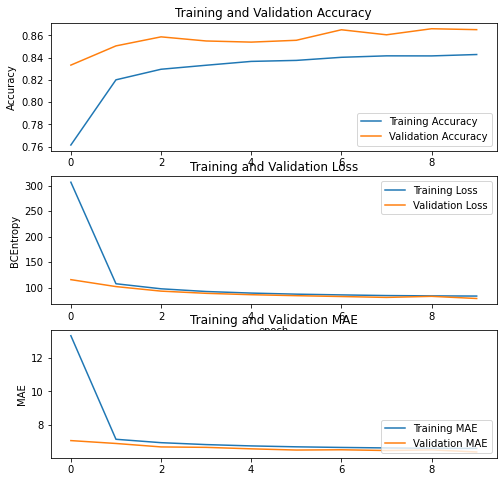

In [57]:
acc = history.history['gender_binary_accuracy']
val_acc = history.history['val_gender_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

mae = history.history['age_mean_absolute_error']
val_mae = history.history['val_age_mean_absolute_error']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(3, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('BCEntropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(3, 1, 3)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.show()

In [58]:
tf_model = '../models/age_gender_efficientnet.h5'
best_model = tf.keras.models.load_model(tf_model)
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
efficientnetb1 (Functional)     (None, 8, 8, 1280)   6575239     sequential[0][0]                 
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1280)         0           efficientnetb1[0][0]             
______________________________________________________________________________________________

In [59]:
import tensorflow as tf

TFLITE_PATH_V1 = '../models/age_gender_mobilenetv3_v2.tflite'

input_array = ['input'] # you need to change it based on your model
output_array = ['output_age', 'output_gender'] # you need to change it based on your model
print("{} -> {}".format(tf_model, TFLITE_PATH_V1))

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.allow_custom_ops=True
converter.experimental_new_converter =True

# I had to explicitly state the ops
converter.target_spec.supported_ops = [tf.compat.v1.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.compat.v1.lite.OpsSet.SELECT_TF_OPS]


tflite_quant_model = converter.convert()

with open(TFLITE_PATH_V1, 'wb') as f:
    f.write(tflite_quant_model)

../models/age_gender_efficientnet.h5 -> ../models/age_gender_mobilenetv3_v2.tflite
INFO:tensorflow:Assets written to: /tmp/tmpqugl4eo8/assets


In [49]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
      layer.trainable =  False